In [1]:
# Importing standard libraries
import sys
import os
import glob
import math 
import csv
from itertools import islice
import pandas as pd
# Importing third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from geopy import distance
#from osgeo import gdal
import rasterio as rio
from pathlib import Path
from parser import parse_i_record, _parse_b_record, igc2df
from datetime import datetime, timedelta
import logging
from pyproj import Geod
from pilot_behavior_functions import parse_b_records_for_gsp, extract_gsp_field_positions, compute_ground_speed_knots, calc_corrected_speed_stats_in_window_overall_course, calc_corrected_speed_stats_in_window_overall_course, correct_speed, median_filter_speeds, compute_bearing, calc_true_airspeed_stats,get_dynamic_subwindow_length,  calc_corrected_speed_stats_in_window, calc_engine_run_speed_stats, compute_time_weighted_average, extract_tas_field_positions, parse_b_records, get_true_airspeed_stats_for_engine_runs_from_row, get_first_engine_agl, get_agl_all_events, count_pct_engine_starts_below_1000, LANDCOVER_CLASSES, calc_speed_mean_post_event_window, calc_speed_mean_std_pre_event_window, convert_to_datetime, define_time_window, load_flight_data, determine_steady_descent_during_pre_event_window, calculate_descent_rate, calculate_distance_traveled, detect_climb_attempt, detect_multiple_start_stop, clean_time_entries, get_first_engine_event, get_terrain_label_at_first_engine_event_gee, parse_int_list, parse_float_list, parse_engine_run_info, get_dem_elevation_gee
from circling import  _filter_short_sequence, detect_circling_loops, compute_TAS, choose_rotation, wrap_angle, _wrap_angle_diff, compute_wind_vector_bearings_from_subset, compute_bearing_sponsor, compute_wind_vector_distance, compute_wind_vector_from_subset, compute_distance_km, angle_difference, extract_circling_segments_with_crossing, compute_tas_from_phase_matched_method, compute_TAS_stats_from_phase_matched, get_phase_matched_drift_stats, compute_true_airspeed_vector, compute_true_airspeed_additive, compute_phase_matched_wind_vector_for_segment, compute_phase_matched_wind_vectors, average_drift_vectors, compute_drift_from_pair, find_phase_matched_pairs, select_wind_vector_from_segments, compute_bearing, compute_wind_vector_from_segment, extract_circling_segments, detect_circling_behavior, detect_overall_circling, compute_overall_heading, compute_heading_transition, _calc_bearing

Window Start: 2024-06-24 23:00:00 Window End: 2024-06-24 23:04:00


In [2]:
## Final Flights data
df = pd.read_csv('transformed data 700 600 150/flights_final.csv', sep="\t", quoting=csv.QUOTE_ALL)
df = df[df['min_speed_while_engine_running (knots)'].notna()]
df = df.reset_index()


In [3]:
idx = 0

In [4]:
igc_filename = df['File'][idx]
base_folder = "TAS"
alt_folder = "TAS_wgc"
igc_file_path = os.path.join(base_folder, igc_filename)
if not os.path.exists(igc_file_path):
    igc_file_path = os.path.join(alt_folder, igc_filename)

# Define the flight date (adjust if necessary)
flight_date_str = df['Date (MM/DD/YYYY)'][idx]
#flight_date_str = "06/04/2023"
# Extract the TAS field positions from the I-record.
tas_positions = extract_tas_field_positions(igc_file_path)
if tas_positions is None:
    raise ValueError("Cannot proceed: TAS field positions were not found.")

# Parse the B records.
b_records = parse_b_records(igc_file_path, tas_positions, flight_date_str)

# Print the first 5 B records (or fewer if not available)
print("\nFirst few B records and extracted TAS values:")
for record in b_records[:5]:
    timestamp_str = record["timestamp"].strftime("%H:%M:%S")
    tas_val = record["TAS"]
    print(f"Time: {timestamp_str}, TAS: {tas_val}")

DEBUG: Found TAS positions: start = 42, end = 46

First few B records and extracted TAS values:
Time: 17:04:51, TAS: 5.901727861771058
Time: 17:04:52, TAS: 8.515118790496759
Time: 17:04:52, TAS: 9.816414686825054
Time: 17:04:54, TAS: 10.815334773218142
Time: 17:04:55, TAS: 10.275377969762419


In [5]:
# Initialize lists to store data
all_flights_data = []
flight_metadata = []

text = Path(igc_file_path).read_text()
df_flight = igc2df(text, flight_date_str)

In [6]:
tas_positions = extract_tas_field_positions(igc_file_path)
if tas_positions is None:
    logging.info("No TAS field found in the I-record; skipping TAS extraction.")
else:
    # Parse the B records to extract TAS values.
    b_records = parse_b_records(igc_file_path, tas_positions, flight_date_str)
    # Create a DataFrame from the parsed TAS records.
    df_tas = pd.DataFrame(b_records)  # Contains 'timestamp' and 'TAS' columns.
    
    # Merge the TAS values into the main DataFrame.
    # This merge is done on 'timestamp'; ensure that the timestamps from igc2df and parse_b_records are compatible.
    df_flight = pd.merge(df_flight, df_tas, on='timestamp', how='left')

# Now your DataFrame (df) should have a TAS column (if it was found in the IGC file).
print(df_flight.head())

DEBUG: Found TAS positions: start = 42, end = 46
            timestamp   latitude  longitude  altitude_press  altitude_gnss_m  \
0 2023-06-04 17:04:51  31.986783 -83.779633             105               65   
1 2023-06-04 17:04:52  31.986783 -83.779633             105               65   
2 2023-06-04 17:04:52  31.986783 -83.779633             105               65   
3 2023-06-04 17:04:52  31.986783 -83.779633             105               65   
4 2023-06-04 17:04:52  31.986783 -83.779633             105               65   

   altitude_gnss_ft       TAS  
0          213.2546  5.901728  
1          213.2546  8.515119  
2          213.2546  9.816415  
3          213.2546  8.515119  
4          213.2546  9.816415  


In [7]:
# Example usage:
window_start = df_flight['timestamp'].iloc[0]
window_end = df_flight['timestamp'].iloc[-1]

circling_segments = detect_circling_loops(
    df_flight,
    min_angle=5,        # e.g. 5 degrees
    min_duration=10,    # e.g. require at least 10 consecutive turning points
    min_full_turn=300,  # require ~ 300+ deg net heading
    crossing_tol_m=100  # e.g. 100 meters to consider "closing" the loop
)

# 4) Inspect the results
for seg in circling_segments:
    print(seg)

{'start_time': Timestamp('2023-06-04 17:38:08'), 'end_time': Timestamp('2023-06-04 17:38:42'), 'start_lat': np.float64(32.091766666666665), 'start_lon': np.float64(-83.75055), 'end_lat': np.float64(32.0917), 'end_lon': np.float64(-83.75021666666666)}
{'start_time': Timestamp('2023-06-04 18:30:52'), 'end_time': Timestamp('2023-06-04 18:31:21'), 'start_lat': np.float64(31.85035), 'start_lon': np.float64(-83.60661666666667), 'end_lat': np.float64(31.8507), 'end_lon': np.float64(-83.60711666666667)}
{'start_time': Timestamp('2023-06-04 19:14:15'), 'end_time': Timestamp('2023-06-04 19:14:41'), 'start_lat': np.float64(31.4516), 'start_lon': np.float64(-83.90296666666667), 'end_lat': np.float64(31.451583333333332), 'end_lon': np.float64(-83.90316666666666)}
{'start_time': Timestamp('2023-06-04 19:41:36'), 'end_time': Timestamp('2023-06-04 19:42:15'), 'start_lat': np.float64(31.3657), 'start_lon': np.float64(-84.48976666666667), 'end_lat': np.float64(31.3648), 'end_lon': np.float64(-84.4897333

In [8]:

start_time_str = str(circling_segments[0]['start_time'])
end_time_str   = str(circling_segments[0]['end_time'])

start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")
end_time   = datetime.strptime(end_time_str, "%Y-%m-%d %H:%M:%S")

# Extend the end time by 10 seconds.
#end_time_extended = end_time + timedelta(seconds=5)

# Now use start_time and end_time_extended to slice your DataFrame.
df_flight_subset = df_flight[
    (df_flight['timestamp'] >= str(start_time)) &
    (df_flight['timestamp'] <= str(end_time))
].copy()

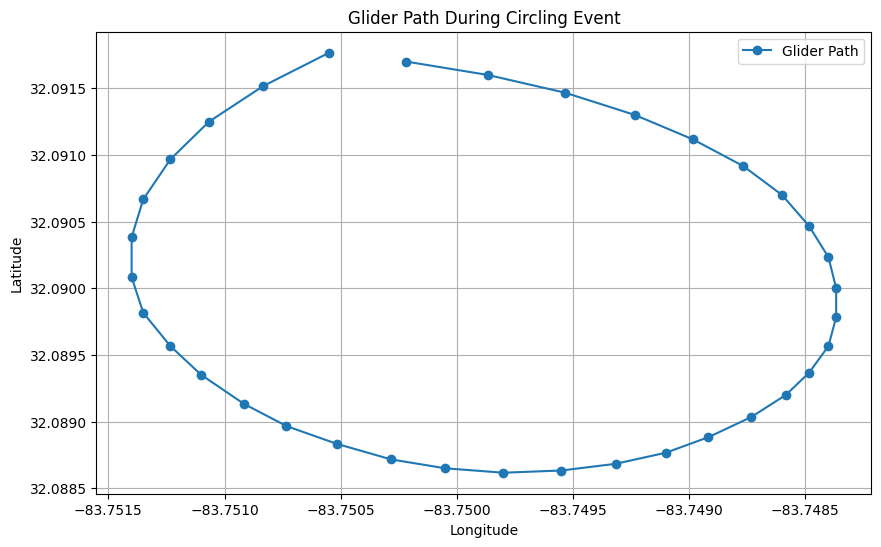

In [9]:
# Plot the glider's path
plt.figure(figsize=(10, 6))
plt.plot(df_flight_subset['longitude'], df_flight_subset['latitude'], marker='o', label='Glider Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Glider Path During Circling Event')
plt.legend()
plt.grid()
plt.show()


In [10]:
start_time_str = str(df['first_event_datetime'][idx])
start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")
end_time   = start_time + timedelta(seconds= 60)

engine_df = df_flight[
    (df_flight['timestamp'] >= str(start_time)) &
    (df_flight['timestamp'] <= str(end_time))
].copy()

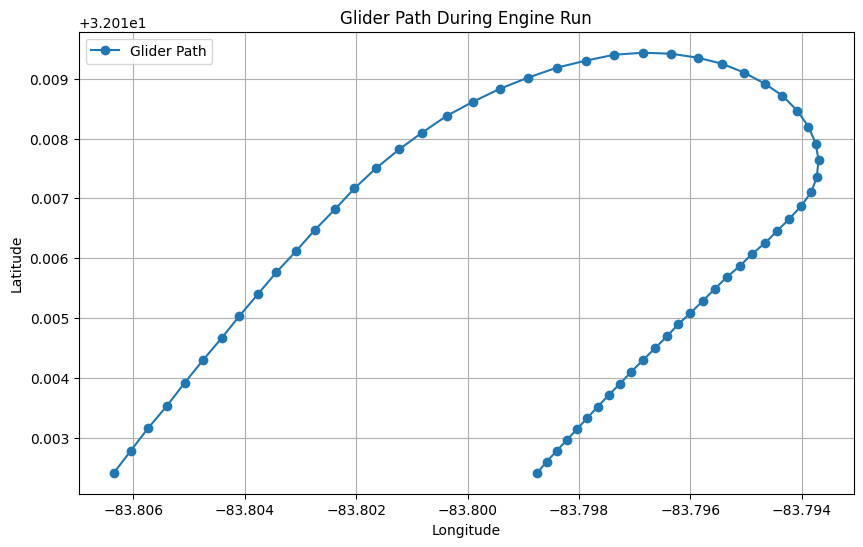

In [11]:
# Plot the glider's path
plt.figure(figsize=(10, 6))
plt.plot(engine_df['longitude'], engine_df['latitude'], marker='o', label='Glider Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Glider Path During Engine Run')
plt.legend()
plt.grid()
plt.show()


In [12]:
df_flight_subset['next_lat'] = df_flight_subset['latitude'].shift(-1)
df_flight_subset['next_lon'] = df_flight_subset['longitude'].shift(-1)

# Compute the calculated bearing for each row (except the last, which has no next fix).
df_flight_subset['Cal Bearing'] = df_flight_subset.apply(
    lambda row: compute_bearing(row['latitude'], row['longitude'], row['next_lat'], row['next_lon'])
    if pd.notnull(row['next_lat']) and pd.notnull(row['next_lon'])
    else None,
    axis=1
)

# Optionally, drop the temporary shifted columns.
df_flight_subset.drop(columns=['next_lat', 'next_lon'], inplace=True)
df_flight_subset["Cal Bearing"] = df_flight_subset["Cal Bearing"].shift(1)


In [13]:
# First, extract the GSP field positions from the I‑record.
gsp_positions = extract_gsp_field_positions(igc_file_path)
if gsp_positions is None:
    raise ValueError("GSP field positions not found in the I record.")

# Next, parse the B‑records to extract GSP values.
gsp_records = parse_b_records_for_gsp(igc_file_path, gsp_positions, flight_date_str)

# Convert the list of dictionaries to a DataFrame.
df_gsp = pd.DataFrame(gsp_records)

# Merge the extracted GSP values with your existing flight subset on the timestamp.
# (Ensure that the timestamps match in format and precision.)
df_flight_subset = pd.merge(df_flight_subset, df_gsp, on='timestamp', how='left', suffixes=('', '_extracted'))


DEBUG: Found GSP positions: start = 47, end = 51


In [14]:
df_flight_subset['next_lat'] = df_flight_subset['latitude'].shift(-1)
df_flight_subset['next_lon'] = df_flight_subset['longitude'].shift(-1)

df_flight_subset['drift_distance'] = df_flight_subset.apply(
    lambda row: compute_distance_km(row['latitude'], row['longitude'],
                                    row['next_lat'], row['next_lon'])
    if pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else None,
    axis=1
)
df_flight_subset["drift_distance"] = df_flight_subset["drift_distance"].shift(1)

# Optionally drop the temporary columns.
df_flight_subset.drop(columns=['next_lat', 'next_lon'], inplace=True)


In [15]:
# Assume df_flight_subset has a column 'drift_distance_km' which contains the drift distance in kilometers.
df_flight_subset['time_diff'] = df_flight_subset['timestamp'].diff().dt.total_seconds()

# For rows where time_diff is > 1 second, we use drift_distance divided by time_diff to get km/s,
# then convert to km/h (by multiplying by 3600) and then to knots (by multiplying by 0.539957).
df_flight_subset['Cal GS Km/time'] = (df_flight_subset['drift_distance'] / df_flight_subset['time_diff']) * 3600 * 0.539957

df_flight_subset.head(3)

,timestamp,latitude,longitude,altitude_press,altitude_gnss_m,altitude_gnss_ft,TAS,Cal Bearing,GSP,drift_distance,time_diff,Cal GS Km/time
0,2023-06-04 17:38:08,32.091767,-83.750550,1269,1284,4212.59856,63.974082,NaN,76.619870,NaN,NaN,NaN
1,2023-06-04 17:38:09,32.091517,-83.750833,1276,1292,4238.84528,61.835853,223.835687,73.536717,0.038538,1.0,74.912364
2,2023-06-04 17:38:10,32.091250,-83.751067,1282,1297,4255.24948,61.592873,216.549661,70.777538,0.036911,1.0,71.748625


In [16]:
# Calculate Cal TS:


In [17]:
def compute_bearing_sponsor(lat_earlier, lon_earlier, lat_later, lon_later):
    """
    Computes the bearing (in degrees) using the sponsor's formula.
    
    The formula is:
      =DEGREES(ATAN2(
            COS(RADIANS(lat_later)) * SIN(RADIANS(lat_earlier))
          - SIN(RADIANS(lat_later)) * COS(RADIANS(lat_earlier)) * COS(RADIANS(lon_earlier - lon_later)),
            SIN(RADIANS(lon_earlier - lon_later)) * COS(RADIANS(lat_earlier))
         ))
         
    In the sponsor's spreadsheet, lat_later comes from B49 and lat_earlier from B23, 
    and similarly for the longitudes.
    """
    num = math.cos(math.radians(lat_later)) * math.sin(math.radians(lat_earlier)) - \
          math.sin(math.radians(lat_later)) * math.cos(math.radians(lat_earlier)) * \
          math.cos(math.radians(lon_earlier - lon_later))
    den = math.sin(math.radians(lon_earlier - lon_later)) * math.cos(math.radians(lat_earlier))
    bearing = math.degrees(math.atan2(num, den))
    # Normalize the bearing to 0-360 degrees.
    return (bearing + 360) % 360

In [18]:
# Parameters: form 7 pairs
num_pairs = 7
offset = len(df_flight_subset) - num_pairs  # This should equal 26 if index 0 corresponds to sponsor's B22 and index 26 to B48

pairs = []
for i in range(num_pairs):
    start_idx = i
    end_idx = i + offset  # e.g. 0 with 26, 1 with 27, …, 6 with 32.
    start_fix = df_flight_subset.loc[start_idx]
    end_fix = df_flight_subset.loc[end_idx]
    
    drift_distance = compute_distance_km(start_fix['latitude'], start_fix['longitude'],
                                         end_fix['latitude'], end_fix['longitude'])
    
    # For the first pair, leave the bearing blank (None)
    if i == 0:
        bearing = None
    else:
        # Reverse the order: use the end fix first and the start fix second
        bearing = compute_bearing(end_fix['latitude'], end_fix['longitude'],
                                  start_fix['latitude'], start_fix['longitude'])
    
    pairs.append((start_idx, end_idx, drift_distance, bearing))
    bearing_str = "" if bearing is None else f"{bearing:.2f}°"
    print(f"Pair {i+1}: Start fix (index {start_idx}) and End fix (index {end_idx}) -> "
          f"Drift Distance: {drift_distance:.3f} km, Bearing: {bearing_str}")

Pair 1: Start fix (index 0) and End fix (index 28) -> Drift Distance: 0.219 km, Bearing: 
Pair 2: Start fix (index 1) and End fix (index 29) -> Drift Distance: 0.206 km, Bearing: 288.92°
Pair 3: Start fix (index 2) and End fix (index 30) -> Drift Distance: 0.197 km, Bearing: 274.32°
Pair 4: Start fix (index 3) and End fix (index 31) -> Drift Distance: 0.192 km, Bearing: 258.87°
Pair 5: Start fix (index 4) and End fix (index 32) -> Drift Distance: 0.193 km, Bearing: 242.54°
Pair 6: Start fix (index 5) and End fix (index 33) -> Drift Distance: 0.198 km, Bearing: 226.88°
Pair 7: Start fix (index 6) and End fix (index 34) -> Drift Distance: 0.212 km, Bearing: 211.80°


In [19]:
# Filter out None values in the bearing (i.e. skip the first pair's bearing).
valid_bearings = [t[3] for t in pairs if t[3] is not None]

# Compute the average of the bearings using circular statistics.
x = sum(math.cos(math.radians(b)) for b in valid_bearings) / len(valid_bearings)
y = sum(math.sin(math.radians(b)) for b in valid_bearings) / len(valid_bearings)

# Compute the average bearing and ensure it's between 0 and 360
circular_avg_bearing = math.degrees(math.atan2(y, x)) % 360

print(f"Circular Average Bearing: {circular_avg_bearing:.2f}°")

Circular Average Bearing: 250.57°


In [20]:
wind_magnitudes = []
start_fix_time = df_flight_subset.loc[start_idx, 'timestamp']
end_fix_time   = df_flight_subset.loc[end_idx,   'timestamp']
true_delta_s   = (end_fix_time - start_fix_time).total_seconds()  # seconds over which the drift distance is measured
conversion_factor = 3600 * 0.539957  # factor to convert km/s to knots

for pair in pairs:
    start_idx, end_idx, drift_distance, bearing = pair
    wind_magnitude = (drift_distance / true_delta_s) * conversion_factor
    wind_magnitudes.append(wind_magnitude)
    print(f"Pair: Start index {start_idx}, End index {end_idx}, "
          f"Drift Distance: {drift_distance:.3f} km, Wind Magnitude: {wind_magnitude:.2f} knots")

Pair: Start index 0, End index 28, Drift Distance: 0.219 km, Wind Magnitude: 15.18 knots
Pair: Start index 1, End index 29, Drift Distance: 0.206 km, Wind Magnitude: 14.29 knots
Pair: Start index 2, End index 30, Drift Distance: 0.197 km, Wind Magnitude: 13.66 knots
Pair: Start index 3, End index 31, Drift Distance: 0.192 km, Wind Magnitude: 13.33 knots
Pair: Start index 4, End index 32, Drift Distance: 0.193 km, Wind Magnitude: 13.39 knots
Pair: Start index 5, End index 33, Drift Distance: 0.198 km, Wind Magnitude: 13.74 knots
Pair: Start index 6, End index 34, Drift Distance: 0.212 km, Wind Magnitude: 14.68 knots


In [21]:
# If wind_magnitudes is a list:
avg_wind_mags = np.mean(wind_magnitudes)
print("Average wind magnitude:", avg_wind_mags)

Average wind magnitude: 14.039479562659096


In [22]:
# Step 1: Compute the chosen rotation.
# -------------------------------------------------------------------

# Compute and store the chosen rotation for each fix.
df_flight_subset['Chosen_Rotation'] = df_flight_subset['Cal Bearing'].apply(lambda x: choose_rotation(x, circular_avg_bearing))

# -------------------------------------------------------------------
# Step 2: Compute Hw/TW.
# -------------------------------------------------------------------
df_flight_subset['Hw/TW_raw'] = df_flight_subset['Cal Bearing'] + df_flight_subset['Chosen_Rotation'] - circular_avg_bearing
# Optionally wrap Hw/TW to [-180, 180) if needed.
df_flight_subset['Hw/TW'] = df_flight_subset['Hw/TW_raw'].apply(wrap_angle)



In [23]:
# -------------------------------------------------------------------
# Step 3: Compute the wind correction magnitude.
# -------------------------------------------------------------------
# The length of the headwind/tailwind component:
df_flight_subset['Sin_HwTW'] = np.sin(np.radians(df_flight_subset['Hw/TW']))
df_flight_subset['abs_correction'] = avg_wind_mags * np.abs(df_flight_subset['Sin_HwTW'])


In [24]:

# -----------------------------------------------------------------------------
# Step 2: Form the two candidate Cal TS values: plus or minus the correction.
# -----------------------------------------------------------------------------
df_flight_subset['Candidate_Add'] = df_flight_subset['Cal GS Km/time'] + df_flight_subset['abs_correction']
df_flight_subset['Candidate_Sub'] = df_flight_subset['Cal GS Km/time'] - df_flight_subset['abs_correction']

# -----------------------------------------------------------------------------
# Step 3: Decide which candidate to pick based on an expected range.
#         If both are in the range, pick the one closer to a nominal speed (e.g. 60).
#         If neither is in range, pick whichever is closer to the nominal.
# -----------------------------------------------------------------------------
expected_min = 44.0
expected_max = 65.0
nominal = 52.0

def pick_cal_ts(row):
    add_val = row['Candidate_Add']
    sub_val = row['Candidate_Sub']
    
    in_range_add = (expected_min <= add_val <= expected_max)
    in_range_sub = (expected_min <= sub_val <= expected_max)
    
    # 1) If only one candidate is in the plausible range, pick that.
    if in_range_add and not in_range_sub:
        return add_val
    if in_range_sub and not in_range_add:
        return sub_val
    
    # 2) If both are in range, pick whichever is closer to nominal.
    if in_range_add and in_range_sub:
        dist_add = abs(add_val - nominal)
        dist_sub = abs(sub_val - nominal)
        return add_val if dist_add < dist_sub else sub_val
    
    # 3) If neither is in range, pick whichever is closer to nominal.
    dist_add = abs(add_val - nominal)
    dist_sub = abs(sub_val - nominal)
    return add_val if dist_add < dist_sub else sub_val

df_flight_subset['Cal TS'] = df_flight_subset.apply(pick_cal_ts, axis=1)

In [25]:
# -------------------------------------------------------------------
# Step 6: Compute diagnostic differences.
# -------------------------------------------------------------------
df_flight_subset['GSP-TAS'] = df_flight_subset['GSP'] - df_flight_subset['TAS']
df_flight_subset['TAS-Cal GS'] = df_flight_subset['TAS'] - df_flight_subset['Cal GS Km/time']
df_flight_subset['TAS-CalTS'] = df_flight_subset['TAS'] - df_flight_subset['Cal TS']


In [26]:
# Compute statistics for the instrument TAS
tas_avg = df_flight_subset['TAS'].mean()
tas_min = df_flight_subset['TAS'].min()
tas_max = df_flight_subset['TAS'].max()

# Similarly, compute statistics for the calculated TS (if desired)
cal_ts_avg = df_flight_subset['Cal TS'].mean()
cal_ts_min = df_flight_subset['Cal TS'].min()
cal_ts_max = df_flight_subset['Cal TS'].max()

print(f"TAS: Average = {tas_avg:.2f} knots, Min = {tas_min:.2f} knots, Max = {tas_max:.2f} knots")
print(f"Cal TS: Average = {cal_ts_avg:.2f} knots, Min = {cal_ts_min:.2f} knots, Max = {cal_ts_max:.2f} knots")


TAS: Average = 57.40 knots, Min = 53.49 knots, Max = 63.97 knots
Cal TS: Average = 56.09 knots, Min = 50.58 knots, Max = 62.37 knots


In [27]:
engine_df.head()

,timestamp,latitude,longitude,altitude_press,altitude_gnss_m,altitude_gnss_ft,TAS
924,2023-06-04 17:18:02,32.012417,-83.798750,1243,1256,4120.73504,64.319654
925,2023-06-04 17:18:03,32.012600,-83.798583,1245,1258,4127.29672,64.157667
926,2023-06-04 17:18:04,32.012783,-83.798400,1247,1261,4137.13924,64.794816
927,2023-06-04 17:18:05,32.012967,-83.798217,1250,1264,4146.98176,65.593952
928,2023-06-04 17:18:06,32.013150,-83.798033,1252,1265,4150.26260,65.971922


In [28]:
# Assumptions:
# - df_flight is a DataFrame for the engine-run segment with columns:
#       'timestamp' (pd.Timestamp), 'latitude', and 'longitude'
#   and is sorted by 'timestamp'.
# - avg_wind_mag is the average wind speed in knots.
# - circular_avg_bearing is the wind "from" bearing in degrees.
# ------------------------------------------------------------------------------
# Example values (replace these with your actual values):
# avg_wind_mag = 20.0           # in knots
# circular_avg_bearing = 231.17  # in degrees

# Ensure the DataFrame is sorted.
df_flight = df_flight.sort_values('timestamp').reset_index(drop=True)

# Create a Geod object for the WGS84 ellipsoid.
geod = Geod(ellps='WGS84')

# ------------------------------------------------------------------------------
# Step 1: Calculate the Wind Vector (convert wind speed from knots to m/s)
# ------------------------------------------------------------------------------
def knots_to_mps(knots):
    return knots / 1.94384  # conversion factor

wind_speed_mps = knots_to_mps(avg_wind_mags)
wind_bearing_rad = math.radians(circular_avg_bearing)
# Meteorological convention: wind "from" bearing.
wind_vx = -wind_speed_mps * math.sin(wind_bearing_rad)  # east component (m/s)
wind_vy = -wind_speed_mps * math.cos(wind_bearing_rad)  # north component (m/s)
print(f"Wind vector (m/s): vx = {wind_vx:.2f}, vy = {wind_vy:.2f}")

# ------------------------------------------------------------------------------
# Step 2: Compute Instantaneous Flight (Ground) Vectors and True Airspeed (TAS)
# ------------------------------------------------------------------------------
instantaneous_TAS = []  # list to store instantaneous TAS values (m/s)
engine_df = engine_df.reset_index(drop=True)

for i in range(1, len(engine_df)):
    # Get consecutive points
    lat1, lon1 = engine_df.loc[i-1, ['latitude', 'longitude']]
    lat2, lon2 = engine_df.loc[i,   ['latitude', 'longitude']]
    
    # Time difference in seconds
    dt = (engine_df.loc[i, 'timestamp'] - engine_df.loc[i-1, 'timestamp']).total_seconds()
    if dt <= 0:
        continue  # skip invalid intervals
    
    # Compute geodesic distance and forward azimuth (degrees)
    azimuth, _, distance = geod.inv(lon1, lat1, lon2, lat2)
    ground_speed = distance / dt  # in m/s
    
    # Decompose ground speed into east and north components:
    az_rad = math.radians(azimuth)
    vx_ground = ground_speed * math.sin(az_rad)
    vy_ground = ground_speed * math.cos(az_rad)
    
    # ------------------------------------------------------------------------------
    # Step 3: Apply Wind Correction to Compute True Airspeed (TAS)
    # ------------------------------------------------------------------------------
    # True airspeed vector = ground velocity vector - wind vector.
    vx_air = vx_ground - wind_vx
    vy_air = vy_ground - wind_vy
    tas = math.sqrt(vx_air**2 + vy_air**2)
    instantaneous_TAS.append(tas)

# Convert instantaneous TAS to a Pandas Series (in m/s) and then to knots.
tas_series_mps = pd.Series(instantaneous_TAS)
tas_series_knots = tas_series_mps * 1.94384

# ------------------------------------------------------------------------------
# Step 4: Apply Rolling Median Smoothing (window = 5)
# ------------------------------------------------------------------------------
tas_rolling_median = tas_series_knots.rolling(window=5, center=True).median().dropna()

# ------------------------------------------------------------------------------
# Step 5: Trim the Smoothed Data (keep values between 25th and 75th percentiles)
# ------------------------------------------------------------------------------
lower_bound = tas_rolling_median.quantile(0.20)
upper_bound = tas_rolling_median.quantile(0.80)
tas_trimmed = tas_rolling_median[(tas_rolling_median >= lower_bound) & (tas_rolling_median <= upper_bound)]

# ------------------------------------------------------------------------------
# Step 6: Compute MIN, MAX, and AVG TAS (knots)
# ------------------------------------------------------------------------------


Wind vector (m/s): vx = 6.81, vy = 2.40


In [29]:
def print_stats(series, label):
    # Filter out any values below 45 or above 90
    filtered = series[(series >= 45) & (series <= 95)]
    
    if len(filtered) == 0:
        print(f"=== {label} ===")
        print("  All instantaneous speeds are outside the 45 to 90 knots range. No stats available.\n")
        return None, None, None
    
    mean_val = filtered.mean()
    min_val = filtered.min()
    max_val = filtered.max()
    
    print(f"=== {label} (Filtered: speeds between 45 and 95 knots) ===")
    print(f"  Min: {min_val:.2f} knots")
    print(f"  Max: {max_val:.2f} knots")
    print(f"  Avg: {mean_val:.2f} knots\n")
    
    return min_val, max_val, mean_val



#print("Raw instantaneous TAS (knots) stats:")
#print_stats(tas_series_knots, "Raw TAS")

#print("Rolling Median Smoothed TAS (knots) stats:")
#print_stats(tas_rolling_median, "Smoothed TAS")



In [30]:
print("Combined (Rolling + Trimmed) TAS (knots) stats:")
print_stats(tas_trimmed, "Combined TAS")

Combined (Rolling + Trimmed) TAS (knots) stats:
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 46.72 knots
  Max: 94.34 knots
  Avg: 60.06 knots



(np.float64(46.716762062827925),
 np.float64(94.3406283652579),
 np.float64(60.060656615459365))

# Loop through all flights

In [31]:
def parse_run_times(val):
    """
    Parse an engine run start time value.
    - If val is NaN or 'nan', return an empty list.
    - If val is a numeric value, convert it to an integer string.
    - If val is a string that starts with '[' assume it’s a list (use ast.literal_eval)
      and convert each element to an integer string.
    - Otherwise, assume it’s a single HHMMSS value.
    """
    # Check for NaN (or a string that is 'nan')
    if pd.isnull(val) or (isinstance(val, str) and val.strip().lower() == 'nan'):
        return []
    try:
        # If numeric, convert directly.
        if isinstance(val, (int, float)):
            return [str(int(val))]
        elif isinstance(val, str):
            val = val.strip()
            # If it looks like a list, parse it.
            if val.startswith('['):
                lst = ast.literal_eval(val)
                # Convert each element to an integer string (if it's not NaN)
                return [str(int(float(x))) for x in lst if pd.notnull(x)]
            else:
                # Otherwise, treat it as a single HHMMSS value.
                return [str(int(float(val)))]
    except Exception as e:
        print(f"Error parsing run time value '{val}': {e}")
        return []


In [32]:
import ast

In [33]:
def pick_cal_ts(add_val, sub_val, expected_min, expected_max, nominal):
    in_range_add = (expected_min <= add_val <= expected_max)
    in_range_sub = (expected_min <= sub_val <= expected_max)
    if in_range_add and not in_range_sub:
        return add_val
    if in_range_sub and not in_range_add:
        return sub_val
    if in_range_add and in_range_sub:
        return add_val if abs(add_val - nominal) < abs(sub_val - nominal) else sub_val
    return add_val if abs(add_val - nominal) < abs(sub_val - nominal) else sub_val



def robust_min(series, k=3):
    med = series.median()
    mad = (series - med).abs().median()
    filtered = series[series >= med - k * mad]
    return filtered.min()


# ------------------------------
# Helper: Robustly parse run durations.
# ------------------------------
def parse_run_durations_debug(s):
    """
    A debug version of parse_run_durations that can handle values like '[480, 420]'.
    """
    print(f"  parse_run_durations_debug received: {repr(s)}")
    if pd.isnull(s):
        print("  -> It's null/NaN in the DataFrame.")
        return []
    
    val_str = str(s).strip()
    if not val_str:
        print("  -> It's an empty string.")
        return []
    
    # If the string is in Python list format (e.g. "[480, 420]"), strip brackets:
    if val_str.startswith('[') and val_str.endswith(']'):
        val_str = val_str[1:-1].strip()  # remove surrounding brackets
    
    try:
        # Attempt to split by comma and convert each piece to float
        out = [float(x.strip()) for x in val_str.split(',') if x.strip()]
        print(f"  -> Successfully parsed: {out}")
        return out
    except Exception as e:
        print(f"  -> Failed to parse '{val_str}' as floats. Error: {e}")
        return []
def parse_engine_run_start_times(flight, flight_date_str, igc_filename,
                                 engine_run_cols=None):
    """
    Given a row (flight) with possible engine run start columns (e.g.
    ['ENL_Engine_Run_Start_Times', 'MOP_Engine_Run_Start_Times', 
     'RPM_Engine_Run_Start_Times']),
    this function gathers all run-start strings, then converts each HHMMSS 
    to a full datetime using flight_date_str. Returns a list of pd.Timestamp.
    
    If no valid times are found, or if a time string is in an incorrect format,
    that time is skipped.
    """
    if engine_run_cols is None:
        engine_run_cols = ['ENL_Engine_Run_Start_Times',
                           'MOP_Engine_Run_Start_Times',
                           'RPM_Engine_Run_Start_Times']
    
    engine_run_start_times = []
    for col in engine_run_cols:
        if col in flight:
            try:
                val = flight[col]
                if pd.isnull(val):
                    continue
                if isinstance(val, str):
                    # May contain multiple comma-separated times
                    if ',' in val:
                        times = [t.strip() for t in val.split(',') if t.strip()]
                    else:
                        times = [val.strip()]
                else:
                    times = [str(val)]
                
                engine_run_start_times.extend(times)
            except Exception as e:
                print(f"Error parsing {col} for {igc_filename}: {e}")
    
    if not engine_run_start_times:
        print(f"No engine run start times found for {igc_filename}")
        return []
    
    run_start_datetimes = []
    for t in engine_run_start_times:
        try:
            # Fix a trailing colon (e.g. "16:28:" -> "16:28:00")
            if t.endswith(":"):
                t = t + "00"
            # If the time string is too short, skip it.
            if len(t) < 6:
                raise ValueError("Time string is too short.")
            # Take only the first 6 characters for HH, MM, SS.
            hh = t[:2]
            mm = t[2:4]
            ss = t[4:6]
            dt_str = f"{flight_date_str} {hh}:{mm}:{ss}"
            run_start_datetimes.append(pd.to_datetime(dt_str))
        except Exception as e:
            print(f"Skipping incorrect datetime format for time '{t}' in flight {igc_filename}: {e}")
    return run_start_datetimes



def pick_cal_ts(add_val, sub_val, expected_min, expected_max, nominal):
    in_range_add = (expected_min <= add_val <= expected_max)
    in_range_sub = (expected_min <= sub_val <= expected_max)
    if in_range_add and not in_range_sub:
        return add_val
    if in_range_sub and not in_range_add:
        return sub_val
    if in_range_add and in_range_sub:
        return add_val if abs(add_val - nominal) < abs(sub_val - nominal) else sub_val
    return add_val if abs(add_val - nominal) < abs(sub_val - nominal) else sub_val


def robust_min(series, k=3):
    med = series.median()
    mad = (series - med).abs().median()
    filtered = series[series >= med - k * mad]
    return filtered.min()



In [34]:
import warnings
import logging
import contextlib
import io
import os
from pathlib import Path
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from pyproj import Geod

# Make sure geod is defined (e.g., WGS84 ellipsoid)
geod = Geod(ellps="WGS84")

# (Assumed utility functions are defined elsewhere):
# - igc2df(text, flight_date_str)
# - parse_run_durations_debug(value)
# - detect_circling_loops(df_flight, min_angle, min_duration, min_full_turn, crossing_tol_m)
# - compute_distance_km(lat1, lon1, lat2, lon2)
# - compute_bearing(lat1, lon1, lat2, lon2)
# - knots_to_mps(knots)
# - print_stats(series, label)  # returns (min, max, avg) and optionally prints stats

# Read glider types and filter for Turbo gliders.
glider_types = pd.read_csv('glider-types - capstone.csv')
turbo_models = glider_types[glider_types['Launch-Type'].str.contains('Turbo', case=False, na=False)]['Model'].unique()

flights_df = pd.read_csv("transformed data 700 600 150/flights_final.csv", sep='\t')
turbo_flights = flights_df[flights_df['Gtype'].isin(turbo_models)].copy()

turbo_results = []


In [35]:
for idx, flight in turbo_flights.iterrows():
    igc_filename = flight['File']
    base_folder = "filtered"
    alt_folder = "filtered_wgc"
    igc_file_path = os.path.join(base_folder, igc_filename)
    if not os.path.exists(igc_file_path):
        igc_file_path = os.path.join(alt_folder, igc_filename)
    flight_date_str = flight['Date (MM/DD/YYYY)']

    # 1) Load & parse IGC
    try:
        text = Path(igc_file_path).read_text()
    except Exception as e:
        print(f"Error reading file {igc_filename}: {e}")
        continue

    df_flight = igc2df(text, flight_date_str)
    if df_flight is None:
        print(f"Skipping flight {igc_filename} due to invalid value in IGC records.")
        continue

    df_flight['timestamp'] = pd.to_datetime(df_flight['timestamp'])
    df_flight = df_flight.sort_values('timestamp').reset_index(drop=True)

    # 2) Parse engine‐run start times
    engine_run_cols = ['ENL_Engine_Run_Start_Times', 
                       'MOP_Engine_Run_Start_Times', 
                       'RPM_Engine_Run_Start_Times']
    engine_run_start_times = []
    for col in engine_run_cols:
        if col in flight:
            val = flight[col]
            if pd.isnull(val):
                continue
            try:
                if isinstance(val, str):
                    if ',' in val:
                        times = [t.strip() for t in val.split(',') if t.strip()]
                    else:
                        times = [val.strip()]
                else:
                    times = [str(val)]
                engine_run_start_times.extend(times)
            except Exception as e:
                print(f"Error parsing {col} for {igc_filename}: {e}")

    if not engine_run_start_times:
        print(f"No engine run start times found for {igc_filename}")
        continue

    # Convert "HHMMSS" strings to Timestamps
    engine_run_start_datetimes = []
    for t in engine_run_start_times:
        try:
            if t.endswith(":"):
                t += "00"  
            run_ts = pd.to_datetime(f"{flight_date_str} {t[:2]}:{t[2:4]}:{t[4:6]}")
            engine_run_start_datetimes.append(run_ts)
        except Exception as e:
            print(f"Error converting time '{t}' to datetime for {igc_filename}: {e}")

    if not engine_run_start_datetimes:
        print(f"No valid engine run start times found for {igc_filename}")
        continue

    # 3) Parse engine‐run durations
    try:
        engine_run_durations = parse_run_durations_debug(flight['engine_run_times (s)'])
    except Exception as e:
        print(f"Error parsing engine run durations for {igc_filename}: {e}")
        continue
    if not engine_run_durations:
        print(f"No engine run durations found for {igc_filename}")
        continue

    # 4) Detect circling segments (optional for wind)
    circling_segments = detect_circling_loops(
        df_flight,
        min_angle=5,
        min_duration=10,
        min_full_turn=300,
        crossing_tol_m=100
    )
    if circling_segments:
        for seg in circling_segments:
            seg['mid_time'] = seg['start_time'] + (seg['end_time'] - seg['start_time']) / 2
    circling_found = bool(circling_segments)

    # Prepare lists to accumulate run-level statistics
    run_min_list = []
    run_max_list = []
    run_avg_list = []
    post_run_min_list = []
    post_run_max_list = []
    post_run_avg_list = []

    # 5) Process each engine run
    for run_start, run_duration in zip(engine_run_start_datetimes, engine_run_durations):
        run_end = run_start + timedelta(seconds=run_duration)

        # For wind estimation, pick the closest circling segment if available.
        if circling_segments:
            closest_segment = min(
                circling_segments,
                key=lambda seg: abs(run_start - seg['mid_time'])
            )
            segment_start = closest_segment['start_time']
            segment_end   = closest_segment['end_time']
        else:
            segment_start = df_flight['timestamp'].iloc[0]
            segment_end   = df_flight['timestamp'].iloc[-1]

        df_segment = df_flight[
            (df_flight['timestamp'] >= segment_start) &
            (df_flight['timestamp'] <= segment_end)
        ]
        if len(df_segment) < 3:
            continue

        num_pairs = 7
        if len(df_segment) < num_pairs + 1:
            continue
        offset = len(df_segment) - num_pairs
        pairs = []
        for i in range(num_pairs):
            start_fix = df_segment.iloc[i]
            end_fix   = df_segment.iloc[i + offset]
            drift_dist_km = compute_distance_km(
                start_fix['latitude'], start_fix['longitude'],
                end_fix['latitude'], end_fix['longitude']
            )
            if i == 0:
                bearing = None
            else:
                bearing = compute_bearing(
                    end_fix['latitude'], end_fix['longitude'],
                    start_fix['latitude'], start_fix['longitude']
                )
            pairs.append((drift_dist_km, bearing))
        conversion_factor = 3600 * 0.539957  # km/s -> knots
        wind_magnitudes = []
        for i, (dist_km, bearing) in enumerate(pairs):
            start_time = df_segment.iloc[i]['timestamp']
            end_time   = df_segment.iloc[i + offset]['timestamp']
            delta_s    = (end_time - start_time).total_seconds()
            wind_magnitudes.append((dist_km / delta_s) * conversion_factor)
        computed_avg_wind_mag = np.mean(wind_magnitudes)
        valid_bearings = [p[1] for p in pairs if p[1] is not None]
        if valid_bearings:
            x_mean = np.mean([math.cos(math.radians(b)) for b in valid_bearings])
            y_mean = np.mean([math.sin(math.radians(b)) for b in valid_bearings])
            computed_circular_avg_bearing = math.degrees(math.atan2(y_mean, x_mean)) % 360
        else:
            computed_circular_avg_bearing = np.nan

        wind_speed_mps   = knots_to_mps(computed_avg_wind_mag)
        wind_bearing_rad = math.radians(computed_circular_avg_bearing)
        wind_vx = -wind_speed_mps * math.sin(wind_bearing_rad)
        wind_vy = -wind_speed_mps * math.cos(wind_bearing_rad)

        # --- Engine Run Window Statistics ---
        engine_df = df_flight[
            (df_flight['timestamp'] >= run_start) &
            (df_flight['timestamp'] <= run_end)
        ].reset_index(drop=True)

        instantaneous_TAS = []
        for i in range(1, len(engine_df)):
            lat1, lon1 = engine_df.loc[i - 1, ['latitude', 'longitude']]
            lat2, lon2 = engine_df.loc[i, ['latitude', 'longitude']]
            dt = (engine_df.loc[i, 'timestamp'] - engine_df.loc[i - 1, 'timestamp']).total_seconds()
            if dt <= 0:
                continue
            azimuth, _, distance = geod.inv(lon1, lat1, lon2, lat2)
            ground_speed = distance / dt  # m/s
            az_rad = math.radians(azimuth)
            vx_ground = ground_speed * math.sin(az_rad)
            vy_ground = ground_speed * math.cos(az_rad)
            vx_air = vx_ground - wind_vx
            vy_air = vy_ground - wind_vy
            tas = math.sqrt(vx_air**2 + vy_air**2)
            instantaneous_TAS.append(tas)
        tas_series_mps   = pd.Series(instantaneous_TAS)
        tas_series_knots = tas_series_mps * 1.94384
        tas_rolling_median = tas_series_knots.rolling(window=5, center=True).median().dropna()
        lower_bound_q = tas_rolling_median.quantile(0.10)
        upper_bound_q = tas_rolling_median.quantile(1.00)
        tas_trimmed = tas_rolling_median[(tas_rolling_median >= lower_bound_q) & (tas_rolling_median <= upper_bound_q)]
        final_min_TAS, final_max_TAS, final_avg_TAS = print_stats(tas_trimmed, "Combined TAS")
        run_min_list.append(final_min_TAS)
        run_max_list.append(final_max_TAS)
        run_avg_list.append(final_avg_TAS)

        # --- 5-Minute Post Engine Run Window Statistics ---
        post_run_start = run_end
        post_run_end = run_end + timedelta(minutes=5)
        post_run_df = df_flight[
            (df_flight['timestamp'] >= post_run_start) &
            (df_flight['timestamp'] <= post_run_end)
        ].reset_index(drop=True)
        if len(post_run_df) < 3:
            post_run_min_list.append(np.nan)
            post_run_max_list.append(np.nan)
            post_run_avg_list.append(np.nan)
        else:
            post_instantaneous_TAS = []
            for i in range(1, len(post_run_df)):
                lat1, lon1 = post_run_df.loc[i - 1, ['latitude', 'longitude']]
                lat2, lon2 = post_run_df.loc[i, ['latitude', 'longitude']]
                dt = (post_run_df.loc[i, 'timestamp'] - post_run_df.loc[i - 1, 'timestamp']).total_seconds()
                if dt <= 0:
                    continue
                azimuth, _, distance = geod.inv(lon1, lat1, lon2, lat2)
                ground_speed = distance / dt  # m/s
                az_rad = math.radians(azimuth)
                vx_ground = ground_speed * math.sin(az_rad)
                vy_ground = ground_speed * math.cos(az_rad)
                vx_air = vx_ground - wind_vx
                vy_air = vy_ground - wind_vy
                tas = math.sqrt(vx_air**2 + vy_air**2)
                post_instantaneous_TAS.append(tas)
            post_tas_series_mps = pd.Series(post_instantaneous_TAS)
            post_tas_series_knots = post_tas_series_mps * 1.94384
            post_tas_rolling_median = post_tas_series_knots.rolling(window=5, center=True).median().dropna()
            # Apply filtering: consider only speeds between 45 and 90 knots.
            final_min_TAS_post, final_max_TAS_post, final_avg_TAS_post = print_stats(post_tas_rolling_median, "Post-run TAS")
            post_run_min_list.append(final_min_TAS_post)
            post_run_max_list.append(final_max_TAS_post)
            post_run_avg_list.append(final_avg_TAS_post)

    # 6) Build one row after ALL runs for this flight
    if len(run_min_list) == 0:
        print(f"No valid engine runs (or no data) for flight {igc_filename}")
        continue

    min_str = ",".join(f"{v:.1f}" for v in run_min_list if pd.notnull(v))
    max_str = ",".join(f"{v:.1f}" for v in run_max_list if pd.notnull(v))
    avg_str = ",".join(f"{v:.1f}" for v in run_avg_list if pd.notnull(v))
    post_min_str = ",".join(f"{v:.1f}" for v in post_run_min_list if pd.notnull(v))
    post_max_str = ",".join(f"{v:.1f}" for v in post_run_max_list if pd.notnull(v))
    post_avg_str = ",".join(f"{v:.1f}" for v in post_run_avg_list if pd.notnull(v))

    turbo_results.append({
        'File': igc_filename,
        'Model': flight.get('Gtype', np.nan),
        'All_Min_TAS_knots':  min_str,
        'All_Max_TAS_knots':  max_str,
        'All_Avg_TAS_knots':  avg_str,
        'All_Post_Run_Min_TAS_knots': post_min_str,
        'All_Post_Run_Max_TAS_knots': post_max_str,
        'All_Post_Run_Avg_TAS_knots': post_avg_str,
        'Circling_Segment_Found': circling_found,
        'Min_Speed_While_Engine_Running_knots': flight.get('min_speed_while_engine_running (knots)', np.nan),
        'Max_Speed_While_Engine_Running_knots': flight.get('max_speed_while_engine_running (knots)', np.nan),
        'Avg_Speed_While_Engine_Running_knots': flight.get('avg_speed_while_engine_running (knots)', np.nan),
    })

# End of flight loop
turbo_results_df = pd.DataFrame(turbo_results)
print("\nOne Row per Flight (Turbo Gliders), comma‐separated TAS stats, plus Circling_Segment_Found:")
print(turbo_results_df)


  parse_run_durations_debug received: '180'
  -> Successfully parsed: [180.0]
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 45.41 knots
  Max: 94.93 knots
  Avg: 69.32 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 45.44 knots
  Max: 81.73 knots
  Avg: 65.06 knots

  parse_run_durations_debug received: '120'
  -> Successfully parsed: [120.0]
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 45.05 knots
  Max: 91.67 knots
  Avg: 54.64 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 45.41 knots
  Max: 94.30 knots
  Avg: 78.68 knots

  parse_run_durations_debug received: '60'
  -> Successfully parsed: [60.0]
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 53.00 knots
  Max: 79.83 knots
  Avg: 58.65 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 45.84 knots
  Max: 69.99 knots
  Avg: 57.46 knots

  parse_run_durations_debug received

In [36]:
turbo_results_df.to_csv("turbo_tas_results_df.csv")

In [37]:

def parse_values(s):
    """
    Given a comma-separated string s or a numeric value, return a list of floats.
    If s is empty or NaN, return an empty list.
    """
    if pd.isna(s):
        return []
    # If s is already numeric, return it as a single-element list.
    if isinstance(s, (float, int)):
        return [float(s)]
    # If s is not a string, convert it.
    if not isinstance(s, str):
        s = str(s)
    if s.strip() == "":
        return []
    try:
        return [float(x.strip()) for x in s.split(",") if x.strip() != ""]
    except Exception as e:
        print(f"Error parsing values: {e}")
        return []


In [38]:

# Load the results DataFrame
df = pd.read_csv("turbo_tas_results_df.csv")

# Lists to store percentage errors for each metric
min_pct_errors = []
max_pct_errors = []
avg_pct_errors = []

# Loop over each flight row
for idx, row in df.iterrows():
    # Parse true values (these are the ground truth values)
    true_min = parse_values(row["Min_Speed_While_Engine_Running_knots"])
    true_max = parse_values(row["Max_Speed_While_Engine_Running_knots"])
    true_avg = parse_values(row["Avg_Speed_While_Engine_Running_knots"])
    
    # Parse estimated values (these are from the All_* columns)
    est_min = parse_values(row["All_Min_TAS_knots"])
    est_max = parse_values(row["All_Max_TAS_knots"])
    est_avg = parse_values(row["All_Avg_TAS_knots"])
    
    # Use the minimum count if lists differ in length
    n_min = min(len(true_min), len(est_min))
    n_max = min(len(true_max), len(est_max))
    n_avg = min(len(true_avg), len(est_avg))
    
    # Compute percentage error for each engine run (estimated minus true, relative to true)
    for i in range(n_min):
        if true_min[i] != 0:
            pct_error = ((est_min[i] - true_min[i]) / true_min[i]) * 100
            min_pct_errors.append(pct_error)
    for i in range(n_max):
        if true_max[i] != 0:
            pct_error = ((est_max[i] - true_max[i]) / true_max[i]) * 100
            max_pct_errors.append(pct_error)
    for i in range(n_avg):
        if true_avg[i] != 0:
            pct_error = ((est_avg[i] - true_avg[i]) / true_avg[i]) * 100
            avg_pct_errors.append(pct_error)


In [39]:
# Compute overall mean and median percentage errors for each metric.
min_pct_mean = np.mean(min_pct_errors) if min_pct_errors else np.nan
min_pct_median = np.median(min_pct_errors) if min_pct_errors else np.nan

max_pct_mean = np.mean(max_pct_errors) if max_pct_errors else np.nan
max_pct_median = np.median(max_pct_errors) if max_pct_errors else np.nan

avg_pct_mean = np.mean(avg_pct_errors) if avg_pct_errors else np.nan
avg_pct_median = np.median(avg_pct_errors) if avg_pct_errors else np.nan

print("Percentage Error Analysis for Turbo Flights:")
print("Min Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(min_pct_mean, min_pct_median))
print("Max Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(max_pct_mean, max_pct_median))
print("Avg Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(avg_pct_mean, avg_pct_median))


Percentage Error Analysis for Turbo Flights:
Min Speed Percentage Error: Mean = -4.29%, Median = -6.68%
Max Speed Percentage Error: Mean = -5.51%, Median = -8.15%
Avg Speed Percentage Error: Mean = -5.00%, Median = -9.04%


In [40]:
# ------------------------------
# Step 0: Read Flight Metadata and Filter for Self-Launch Gliders
# ------------------------------
glider_types = pd.read_csv('glider-types - capstone.csv')
self_launch_models = glider_types[glider_types['Launch-Type'].str.contains('Self-Launch', case=False, na=False)]['Model'].unique()
#flights_df = pd.read_csv('flights_final.csv', sep="\t")
flights_df=flights_df[flights_df['min_speed_while_engine_running (knots)']!="0.00"]
self_launch_flights = flights_df[flights_df['Gtype'].isin(self_launch_models)].copy()
geod = Geod(ellps='WGS84')



In [41]:
self_launch_results = []

In [42]:
for idx, flight in self_launch_flights.iterrows():
    igc_filename = flight['File']
    base_folder = "filtered"
    alt_folder = "filtered_wgc"
    igc_file_path = os.path.join(base_folder, igc_filename)
    if not os.path.exists(igc_file_path):
        igc_file_path = os.path.join(alt_folder, igc_filename)
    flight_date_str = flight['Date (MM/DD/YYYY)']

    # 1) Load & parse IGC
    try:
        text = Path(igc_file_path).read_text()
    except Exception as e:
        print(f"Error reading file {igc_filename}: {e}")
        continue

    df_flight = igc2df(text, flight_date_str)
    if df_flight is None:
        print(f"Skipping flight {igc_filename} due to invalid value in IGC records.")
        continue

    df_flight['timestamp'] = pd.to_datetime(df_flight['timestamp'])
    df_flight = df_flight.sort_values('timestamp').reset_index(drop=True)

    # 2) Parse engine‐run start times
    engine_run_cols = ['ENL_Engine_Run_Start_Times', 
                       'MOP_Engine_Run_Start_Times', 
                       'RPM_Engine_Run_Start_Times']
    engine_run_start_times = []
    for col in engine_run_cols:
        if col in flight:
            val = flight[col]
            if pd.isnull(val):
                continue
            try:
                if isinstance(val, str):
                    if ',' in val:
                        times = [t.strip() for t in val.split(',') if t.strip()]
                    else:
                        times = [val.strip()]
                else:
                    times = [str(val)]
                engine_run_start_times.extend(times)
            except Exception as e:
                print(f"Error parsing {col} for {igc_filename}: {e}")

    if not engine_run_start_times:
        print(f"No engine run start times found for {igc_filename}")
        continue

    # Convert "HHMMSS" strings to Timestamps
    engine_run_start_datetimes = []
    for t in engine_run_start_times:
        try:
            if t.endswith(":"):
                t += "00"  
            run_ts = pd.to_datetime(f"{flight_date_str} {t[:2]}:{t[2:4]}:{t[4:6]}")
            engine_run_start_datetimes.append(run_ts)
        except Exception as e:
            print(f"Error converting time '{t}' to datetime for {igc_filename}: {e}")

    if not engine_run_start_datetimes:
        print(f"No valid engine run start times found for {igc_filename}")
        continue

    # 3) Parse engine‐run durations
    try:
        engine_run_durations = parse_run_durations_debug(flight['engine_run_times (s)'])
    except Exception as e:
        print(f"Error parsing engine run durations for {igc_filename}: {e}")
        continue
    if not engine_run_durations:
        print(f"No engine run durations found for {igc_filename}")
        continue

    # 4) Detect circling segments (optional for wind)
    circling_segments = detect_circling_loops(
        df_flight,
        min_angle=5,
        min_duration=10,
        min_full_turn=300,
        crossing_tol_m=100
    )
    if circling_segments:
        for seg in circling_segments:
            seg['mid_time'] = seg['start_time'] + (seg['end_time'] - seg['start_time']) / 2
    circling_found = bool(circling_segments)

    # Prepare lists to accumulate run-level statistics
    run_min_list = []
    run_max_list = []
    run_avg_list = []
    post_run_min_list = []
    post_run_max_list = []
    post_run_avg_list = []

    # 5) Process each engine run
    for run_start, run_duration in zip(engine_run_start_datetimes, engine_run_durations):
        run_end = run_start + timedelta(seconds=run_duration)

        # For wind estimation, pick the closest circling segment if available.
        if circling_segments:
            closest_segment = min(
                circling_segments,
                key=lambda seg: abs(run_start - seg['mid_time'])
            )
            segment_start = closest_segment['start_time']
            segment_end   = closest_segment['end_time']
        else:
            segment_start = df_flight['timestamp'].iloc[0]
            segment_end   = df_flight['timestamp'].iloc[-1]

        df_segment = df_flight[
            (df_flight['timestamp'] >= segment_start) &
            (df_flight['timestamp'] <= segment_end)
        ]
        if len(df_segment) < 3:
            continue

        num_pairs = 7
        if len(df_segment) < num_pairs + 1:
            continue
        offset = len(df_segment) - num_pairs
        pairs = []
        for i in range(num_pairs):
            start_fix = df_segment.iloc[i]
            end_fix   = df_segment.iloc[i + offset]
            drift_dist_km = compute_distance_km(
                start_fix['latitude'], start_fix['longitude'],
                end_fix['latitude'], end_fix['longitude']
            )
            if i == 0:
                bearing = None
            else:
                bearing = compute_bearing(
                    end_fix['latitude'], end_fix['longitude'],
                    start_fix['latitude'], start_fix['longitude']
                )
            pairs.append((drift_dist_km, bearing))
        conversion_factor = 3600 * 0.539957  # km/s -> knots
        wind_magnitudes = []
        for i, (dist_km, bearing) in enumerate(pairs):
            start_time = df_segment.iloc[i]['timestamp']
            end_time   = df_segment.iloc[i + offset]['timestamp']
            delta_s    = (end_time - start_time).total_seconds()
            wind_magnitudes.append((dist_km / delta_s) * conversion_factor)
        computed_avg_wind_mag = np.mean(wind_magnitudes)
        valid_bearings = [p[1] for p in pairs if p[1] is not None]
        if valid_bearings:
            x_mean = np.mean([math.cos(math.radians(b)) for b in valid_bearings])
            y_mean = np.mean([math.sin(math.radians(b)) for b in valid_bearings])
            computed_circular_avg_bearing = math.degrees(math.atan2(y_mean, x_mean)) % 360
        else:
            computed_circular_avg_bearing = np.nan

        wind_speed_mps   = knots_to_mps(computed_avg_wind_mag)
        wind_bearing_rad = math.radians(computed_circular_avg_bearing)
        wind_vx = -wind_speed_mps * math.sin(wind_bearing_rad)
        wind_vy = -wind_speed_mps * math.cos(wind_bearing_rad)

        # --- Engine Run Window Statistics ---
        engine_df = df_flight[
            (df_flight['timestamp'] >= run_start) &
            (df_flight['timestamp'] <= run_end)
        ].reset_index(drop=True)

        instantaneous_TAS = []
        for i in range(1, len(engine_df)):
            lat1, lon1 = engine_df.loc[i - 1, ['latitude', 'longitude']]
            lat2, lon2 = engine_df.loc[i, ['latitude', 'longitude']]
            dt = (engine_df.loc[i, 'timestamp'] - engine_df.loc[i - 1, 'timestamp']).total_seconds()
            if dt <= 0:
                continue
            azimuth, _, distance = geod.inv(lon1, lat1, lon2, lat2)
            ground_speed = distance / dt  # m/s
            az_rad = math.radians(azimuth)
            vx_ground = ground_speed * math.sin(az_rad)
            vy_ground = ground_speed * math.cos(az_rad)
            vx_air = vx_ground - wind_vx
            vy_air = vy_ground - wind_vy
            tas = math.sqrt(vx_air**2 + vy_air**2)
            instantaneous_TAS.append(tas)
        tas_series_mps   = pd.Series(instantaneous_TAS)
        tas_series_knots = tas_series_mps * 1.94384
        tas_rolling_median = tas_series_knots.rolling(window=5, center=True).median().dropna()
        lower_bound_q = tas_rolling_median.quantile(0.10)
        upper_bound_q = tas_rolling_median.quantile(1.00)
        tas_trimmed = tas_rolling_median[(tas_rolling_median >= lower_bound_q) & (tas_rolling_median <= upper_bound_q)]
        final_min_TAS, final_max_TAS, final_avg_TAS = print_stats(tas_trimmed, "Combined TAS")
        run_min_list.append(final_min_TAS)
        run_max_list.append(final_max_TAS)
        run_avg_list.append(final_avg_TAS)

        # --- 5-Minute Post Engine Run Window Statistics ---
        post_run_start = run_end
        post_run_end = run_end + timedelta(minutes=5)
        post_run_df = df_flight[
            (df_flight['timestamp'] >= post_run_start) &
            (df_flight['timestamp'] <= post_run_end)
        ].reset_index(drop=True)
        if len(post_run_df) < 3:
            post_run_min_list.append(np.nan)
            post_run_max_list.append(np.nan)
            post_run_avg_list.append(np.nan)
        else:
            post_instantaneous_TAS = []
            for i in range(1, len(post_run_df)):
                lat1, lon1 = post_run_df.loc[i - 1, ['latitude', 'longitude']]
                lat2, lon2 = post_run_df.loc[i, ['latitude', 'longitude']]
                dt = (post_run_df.loc[i, 'timestamp'] - post_run_df.loc[i - 1, 'timestamp']).total_seconds()
                if dt <= 0:
                    continue
                azimuth, _, distance = geod.inv(lon1, lat1, lon2, lat2)
                ground_speed = distance / dt  # m/s
                az_rad = math.radians(azimuth)
                vx_ground = ground_speed * math.sin(az_rad)
                vy_ground = ground_speed * math.cos(az_rad)
                vx_air = vx_ground - wind_vx
                vy_air = vy_ground - wind_vy
                tas = math.sqrt(vx_air**2 + vy_air**2)
                post_instantaneous_TAS.append(tas)
            post_tas_series_mps = pd.Series(post_instantaneous_TAS)
            post_tas_series_knots = post_tas_series_mps * 1.94384
            post_tas_rolling_median = post_tas_series_knots.rolling(window=5, center=True).median().dropna()
            # Apply filtering: consider only speeds between 45 and 90 knots.
            final_min_TAS_post, final_max_TAS_post, final_avg_TAS_post = print_stats(post_tas_rolling_median, "Post-run TAS")
            post_run_min_list.append(final_min_TAS_post)
            post_run_max_list.append(final_max_TAS_post)
            post_run_avg_list.append(final_avg_TAS_post)

    # 6) Build one row after ALL runs for this flight
    if len(run_min_list) == 0:
        print(f"No valid engine runs (or no data) for flight {igc_filename}")
        continue

    min_str = ",".join(f"{v:.1f}" for v in run_min_list if pd.notnull(v))
    max_str = ",".join(f"{v:.1f}" for v in run_max_list if pd.notnull(v))
    avg_str = ",".join(f"{v:.1f}" for v in run_avg_list if pd.notnull(v))
    post_min_str = ",".join(f"{v:.1f}" for v in post_run_min_list if pd.notnull(v))
    post_max_str = ",".join(f"{v:.1f}" for v in post_run_max_list if pd.notnull(v))
    post_avg_str = ",".join(f"{v:.1f}" for v in post_run_avg_list if pd.notnull(v))

    self_launch_results.append({
        'File': igc_filename,
        'Model': flight.get('Gtype', np.nan),
        'All_Min_TAS_knots':  min_str,
        'All_Max_TAS_knots':  max_str,
        'All_Avg_TAS_knots':  avg_str,
        'All_Post_Run_Min_TAS_knots': post_min_str,
        'All_Post_Run_Max_TAS_knots': post_max_str,
        'All_Post_Run_Avg_TAS_knots': post_avg_str,
        'Circling_Segment_Found': circling_found,
        'Min_Speed_While_Engine_Running_knots': flight.get('min_speed_while_engine_running (knots)', np.nan),
        'Max_Speed_While_Engine_Running_knots': flight.get('max_speed_while_engine_running (knots)', np.nan),
        'Avg_Speed_While_Engine_Running_knots': flight.get('avg_speed_while_engine_running (knots)', np.nan),
    })

# End of flight loop
self_launch_results_df = pd.DataFrame(self_launch_results)
print("\nOne Row per Flight (Self-Launch Gliders), comma‐separated TAS stats, plus Circling_Segment_Found:")
print(self_launch_results_df)


  parse_run_durations_debug received: '300,660'
  -> Successfully parsed: [300.0, 660.0]
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 54.30 knots
  Max: 90.80 knots
  Avg: 65.92 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 53.83 knots
  Max: 87.12 knots
  Avg: 68.67 knots

=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 56.86 knots
  Max: 80.44 knots
  Avg: 66.43 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 51.01 knots
  Max: 78.82 knots
  Avg: 63.50 knots

  parse_run_durations_debug received: '240,120,240'
  -> Successfully parsed: [240.0, 120.0, 240.0]
=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 55.41 knots
  Max: 67.44 knots
  Avg: 61.87 knots

=== Post-run TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 51.74 knots
  Max: 67.82 knots
  Avg: 61.50 knots

=== Combined TAS (Filtered: speeds between 45 and 95 knots) ===
  Min: 57.92 kn

In [43]:
self_launch_results_df.to_csv("self_launch_results_df.csv")

In [44]:
# Load the results DataFrame from self_launch_results_df.csv
#df = pd.read_csv("transformed data 700 600 150/self_launch_results_df.csv")


In [45]:

# Lists to store percentage errors for each metric.
# Percentage error is computed as ((estimated - true) / true)*100.
min_pct_errors = []
max_pct_errors = []
avg_pct_errors = []

for idx, row in df.iterrows():
    # Parse true values (from the true columns)
    true_min = parse_values(row["Min_Speed_While_Engine_Running_knots"])
    true_max = parse_values(row["Max_Speed_While_Engine_Running_knots"])
    true_avg = parse_values(row["Avg_Speed_While_Engine_Running_knots"])
    
    # Parse estimated values (from the estimated columns)
    est_min = parse_values(row["All_Min_TAS_knots"])
    est_max = parse_values(row["All_Max_TAS_knots"])
    est_avg = parse_values(row["All_Avg_TAS_knots"])
    
    # Exclude the first estimate (index 0) for each metric.
    true_min = true_min[1:] if len(true_min) > 1 else []
    true_max = true_max[1:] if len(true_max) > 1 else []
    true_avg = true_avg[1:] if len(true_avg) > 1 else []
    
    est_min = est_min[1:] if len(est_min) > 1 else []
    est_max = est_max[1:] if len(est_max) > 1 else []
    est_avg = est_avg[1:] if len(est_avg) > 1 else []
    
    # For each metric, process up to the minimum number of values available
    n_min = min(len(true_min), len(est_min))
    n_max = min(len(true_max), len(est_max))
    n_avg = min(len(true_avg), len(est_avg))
    
    # Compute percentage errors for minimum speeds
    for i in range(n_min):
        if true_min[i] != 0:
            error_pct = ((est_min[i] - true_min[i]) / true_min[i]) * 100
            min_pct_errors.append(error_pct)
    # Compute percentage errors for maximum speeds
    for i in range(n_max):
        if true_max[i] != 0:
            error_pct = ((est_max[i] - true_max[i]) / true_max[i]) * 100
            max_pct_errors.append(error_pct)
    # Compute percentage errors for average speeds
    for i in range(n_avg):
        if true_avg[i] != 0:
            error_pct = ((est_avg[i] - true_avg[i]) / true_avg[i]) * 100
            avg_pct_errors.append(error_pct)

# Compute overall mean and median percentage error for each metric
min_mean_pct = np.mean(min_pct_errors) if min_pct_errors else np.nan
min_median_pct = np.median(min_pct_errors) if min_pct_errors else np.nan

max_mean_pct = np.mean(max_pct_errors) if max_pct_errors else np.nan
max_median_pct = np.median(max_pct_errors) if max_pct_errors else np.nan

avg_mean_pct = np.mean(avg_pct_errors) if avg_pct_errors else np.nan
avg_median_pct = np.median(avg_pct_errors) if avg_pct_errors else np.nan

print("Self Launch Results Error Percentage Analysis (excluding first estimate):")
print("Min Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(min_mean_pct, min_median_pct))
print("Max Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(max_mean_pct, max_median_pct))
print("Avg Speed Percentage Error: Mean = {:.2f}%, Median = {:.2f}%".format(avg_mean_pct, avg_median_pct))

Self Launch Results Error Percentage Analysis (excluding first estimate):
Min Speed Percentage Error: Mean = 5.18%, Median = 1.24%
Max Speed Percentage Error: Mean = 1.23%, Median = -4.59%
Avg Speed Percentage Error: Mean = 6.45%, Median = 2.61%


In [46]:
turbo_results_df = pd.read_csv("turbo_tas_results_df.csv")
self_launch_results_df = pd.read_csv("self_launch_results_df.csv")

In [47]:
# 1) Read your final flights CSV
flights_final = pd.read_csv("transformed data 700 600 150/flights_final.csv", sep="\t")

# 2) Select relevant columns from each results DataFrame
			
#turbo_estimates = pd.read_csv("transformed data 700 600 150/turbo_tas_results_df.csv")
#self_launch_estimates = pd.read_csv("transformed data 700 600 150/self_launch_results_df.csv")
turbo_estimates = turbo_results_df[
    ["File", "All_Min_TAS_knots", "All_Max_TAS_knots", "All_Avg_TAS_knots", "All_Post_Run_Min_TAS_knots", "All_Post_Run_Max_TAS_knots", 
        "All_Post_Run_Avg_TAS_knots","Circling_Segment_Found", "Min_Speed_While_Engine_Running_knots", "Max_Speed_While_Engine_Running_knots", "Avg_Speed_While_Engine_Running_knots"]
]
self_launch_estimates = self_launch_results_df[
    ["File", "All_Min_TAS_knots", "All_Max_TAS_knots", "All_Avg_TAS_knots", "All_Post_Run_Min_TAS_knots", "All_Post_Run_Max_TAS_knots", 
        "All_Post_Run_Avg_TAS_knots", "Circling_Segment_Found", "Min_Speed_While_Engine_Running_knots", "Max_Speed_While_Engine_Running_knots", "Avg_Speed_While_Engine_Running_knots"]
]

# 3) Concatenate them into a single "all_estimates" DataFrame
all_estimates = pd.concat([turbo_estimates, self_launch_estimates], ignore_index=True)

# 4) If a File appears in both sets (turbo & self-launch), we keep the first occurrence
all_estimates.drop_duplicates(subset=["File"], keep="first", inplace=True)

# 5) Merge the "all_estimates" with the 'flights_final' on the 'File' column
merged_df = pd.merge(flights_final, all_estimates, on="File", how="left")

# 6) Convert 'engine_run_times (s)' and 'height_gain_loss (ft)' from list-like strings 
#    by removing square brackets. Make sure they're actually strings first:
merged_df['engine_run_times (s)'] = merged_df['engine_run_times (s)'].astype(str).replace(r'[\[\]]', '', regex=True)
merged_df['height_gain_loss (ft)'] = merged_df['height_gain_loss (ft)'].astype(str).replace(r'[\[\]]', '', regex=True)

# 7) Finally, write out to a new CSV. 
merged_df.to_csv("flights_final_with_estimates.csv", sep="\t", index=False, quoting=csv.QUOTE_ALL)
print("Merged CSV saved successfully!")

Merged CSV saved successfully!


In [48]:
print(merged_df['engine_run_times (s)'].head())

0        180
1        120
2         60
3    120,240
4         60
Name: engine_run_times (s), dtype: object
